# project08_ver02
- optimizer 변경 (1e-4 -> 2e-5)
- EPOCHS 변경 (50 -> 150)

In [1]:
# 필요 라이브러리 불러오기
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
print(imageio.__version__)

2.6.0
2.9.0


## 데이터셋 구성하기

In [2]:
# 데이터셋 구성하기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

32x32 픽셀의 이미지로 0 ~ 255 사이의 정숫값을 가지는 것을 알 수 있습니다. 확인을 해보겠습니다.

In [3]:
# 픽셀 값 확인하기
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


픽셀을 -1.0, 1.0으로 정규화하여 사용할 예정입니다. 중간값을 맞춰주기 위해 정규화를 진행합니다.

In [4]:
# 정규화 작업하기
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


 float64는 float32에 비해 두 배의 메모리를 사용하기에 float32로 변경해줍니다.   
 floast32는 학습 속도를 높이고 메모리 사용을 줄이는 데 도움이 됩니다.

In [5]:
# train_x type 변환하기
print(train_x.dtype)

train_x = train_x.astype('float32')

print(train_x.dtype)
print(train_x.shape)

float64
float32
(50000, 32, 32, 3)


dtype이 변경된 것을 확인할 수 있습니다.

이제 첫 번째 데이터가 어떻게 생겼는지 확인을 해봅니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


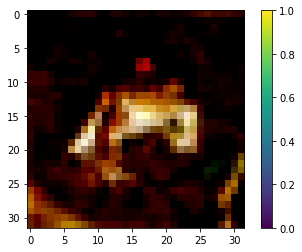

In [6]:
# train_x 첫 번째 이미지 확인하기
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

이미지를 보여주는 `imshow()`함수는 픽셀 값을 0.0에서 1.0사이의 값으로 기대합니다. 하지만 정규화를 진행한 train_x는 -1.0과 1.0의 값을 가지게 됩니다. 그래서 `imshow()`함수에 전달하면 이미지가 어둡게 표현됩니다.

이 문제를 아래와 같이 바꿔서 확인할 수 있습니다.

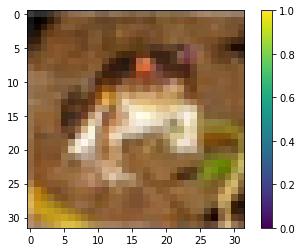

In [7]:
# train_x 첫 번째 이미지 확인하기
plt.imshow((train_x[0] + 1) / 2) # 정규화 된 이미지를 0.0에서 1.0사이의 값으로 재변환하여 확인
plt.colorbar() 
plt.show()

위 두 그림을 확인하면 알 수 있듯이 이미지를 0.0에서 1.0사이의 값으로 재변환해야 이미지를 확인할 수 있는 것을 알수 있습니다.

아래 10개의 이미지를 확인할 때도 재변환하여 확인 해보겠습니다.

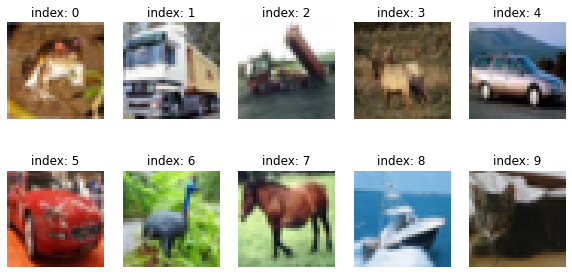

In [8]:
# for문을 활용하여 이미지 10개 확인해보기
plt.figure(figsize=(10, 5))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow((train_x[i] + 1) / 2) # 정규화 된 이미지를 0.0에서 1.0사이의 값으로 재변환하여 확인
  plt.title(f'index: {i}')
  plt.axis('off')
plt.show()

미니 배치 학습 구성해보기

In [9]:
# 미니 배치 학습 구성해보기 (변수 지정)
BUFFER_SIZE = 50000
BATCH_SIZE = 256

`BUFFER_SIZE`는 전체 데이터를 섞기 위해 50,000으로 설정합니다.   
`shffle()`함수가 데이터셋을 잘 석어서 모델을 변수에 할당합니다.   
`BATCH_SIZE`는 모델이 한 번에 학습할 데이터 양을 정해줍니다.

`tf.data.Dataset` 모듈의 `from_tensor_slices()` 함수를 사용하여 미니배치 데이터셋을 구성해보기

In [11]:
# 미니 배치 데이터셋 구성해보기
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

`tf.data.Dataset` 모듈의 `from_tensor_slices()` 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다.   
위 코드는 `train_x`라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 한다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

## 생성자 모델 구현하기

In [12]:
# 생성자 모델 함수로 구현하기
def make_generator_model():
  model = tf.keras.Sequential()

  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))

  model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

  return model

그럼 생성 모델을 `generator`라는 변수로 생성하고, 모델 세부 내용인 `summary`를 출력해봅니다.

In [13]:
# 변수 지정 후 세부 내용 확인해보기
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

모델이 만들어 졌으니, `shape=(1, 100)`의 형상을 가지는 랜덤 노이즈 벡터를 생성하여 결과물을 확인해봅니다.

`tf.random.normal`을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있습니다.

In [14]:
noise = tf.random.normal([1, 100])

텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성됩니다. (내부적으로는 생성자의 call 함수가 호출됩니다).

단, 지금은 학습하는 중이 아니니 `training=False`를 설정해 주어야합니다! Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 `training=False`을 주어야 올바른 결과를 얻을 수 있습니다.

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

`[1, 32, 32, 1]` 사이즈의 이미지가 생성된 것을 확인할 수 있습니다.   
첫 번째 1은 1개(batch_size = 1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가지게 됩니다.

그렇다면 이 이미지를 시각화 해보겠습니다..   
`matplotlib` 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축 인덱스를 0으로 설정해서 `(32, 32)`shape의 이미지를 꺼낼 수 있도록 해야합니다.

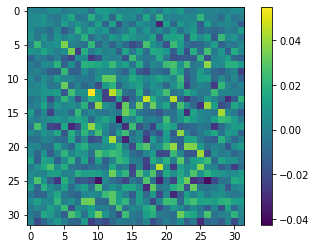

In [16]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

-1 과 1 사이의 값에서 적당히 잘 생성된 것을 확인할 수 있습니다.   
아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성 되었습니다. 모델이 점차 학습해 나가면서 제대로 된 이미지를 생성하는 것을 확인해보도록 하겠습니다.

## 판별자 모델 구현하기

판별자는 앞서 알아봤듯 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야합니다.   
그렇다면 입력은 (32, 32, 3) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것입니다..

In [17]:
def make_discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())

  model.add(layers.Dense(1))

  return model

판별자 또한 `make_discriminator_model` 함수로 구현하였습니다.

`Conv2DTranspose` 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 `Conv2D` 층으로 이미지의 크기를 점점 줄여나갑니다. 첫 번째 Conv2D 층에서 입력된 `[32, 32, 3]` 사이즈의 이미지는 다음 층을 거치며 `(32, 32, 3) → (16, 16, 64) → (8, 8, 128)`까지 줄어들게 됩니다.

마지막에는 `Flatten` 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환합니다. 이는 생성자의 `Reshape` 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 1차원 벡터로 변환한 후에는 마지막 `Dense Layer`를 거쳐 단 하나의 값을 출력하게 됩니다.

판별 모델을 `discriminator`라는 변수 이름으로 생성하고, 모델 세부 내용인 `summary`를 출력해봅니다.

In [18]:
# 변수 지정 후 세부 내용 확인해보기
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

그렇다면 아까 생성했던 가짜 이미지를 판별자에 입력시키면 어떤 결과가 나올지 확인해봅니다.

In [19]:
# 가짜 이미지를 판별자로 확인해보기
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00010533]], dtype=float32)>

텐서 형태로 출력 되었습니다. 이 값은 아무런 의미가 없는 값일 것이므로 모델 학습을 해보기로 합니다.

## 손실함수 (loss function) 구현하기

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용합니다. 교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수이죠. 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰입니다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것입니다.

Real Image에 대한 라벨을 `1`, Fake Image에 대한 라벨을 `0`으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같겠죠.

- 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 `D(fake_image)` 값이 `1`에 가까워지는 것
- 판별자 : Real Image 판별값, 즉 `D(real_image)`는 `1`에, Fake Image 판별값, 즉 `D(fake_image)`는 `0`에 가까워지는 것

결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 되겠네요! 이러한 기준을 가지고 생성자, 판별자 각각에 대한 손실함수를 설계해 봅시다.


손실함수에 사용할 교차 엔트로피 함수는 `tf.keras.losses` 라이브러리 안에 있습니다.

다만, 우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었습니다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있죠.

그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다 (참고). 따라서 `from_logits`를 `True`로 설정해 주어야 `BinaryCrossEntropy`에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.

In [20]:
# 손실함수 구현하기
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

그럼, 이제 `cross_entropy`를 활용해 계산할 loss들은 `fake_output`와 `real_output`, 두 가지를 활용합니다.

- `fake_output` : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 `D(fake_image)`
- `real_output` : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 `D(real_image)`

그럼 이제, `fake_output`과 `real_output`을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까요?

바로 `tf.ones_like()`와 `tf.zeros_like()` 함수를 활용하면 됩니다.

In [21]:
# generator_loss 구현하기
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

`generator_loss`는 `fake_output`가 1에 가까워지기를 바라므로, 다음과 같이 `tf.ones_like`와의 교차 엔트로피값을 계산하면 됩니다.
즉, `cross_entropy(tf.ones_like(fake_output), fake_output)` 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [22]:
# discriminator_loss 구현하기
def discriminator_loss (real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)

  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss

  return total_loss

반면, `discriminator_loss`는 `real_output` 값은 1에 가까워지기를, `fake_output` 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. `real_output`은 1로 채워진 벡터와, `fake_output`은 0으로 채워진 벡터와 비교하면 되겠죠!

최종 `discriminator_loss` 값은 이 둘을 더한 값입니다.

**discriminator accuracy**  
한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요합니다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같습니다.

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

- (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
    - `>> tf.Tensor([False, False, True, True])`
    
- (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
    - `>> tf.Tensor([0.0, 0.0, 1.0, 1.0])`
    
- (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
    - `>> 0.5`

## 최적화 함수(optimizer)

이번에는 Adam 최적화 기법 을 활용해 보겠습니다.

중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.

In [24]:
# optimizer 구현하기
generator_optimizer = tf.keras.optimizers.Adam(2e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5)

매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.

샘플은 한 번에 16장을 생성하도록 하겠습니다.
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
즉, 100차원의 노이즈를 총 16개, `(16, 100)` 형상의 벡터를 만들어 두도록 하겠습니다.

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [26]:
# 훈련코드 구현하기
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [27]:
# 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 구현하기
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2.0) # 픽셀 값 범위를 0.0에서 1.0으로 변환
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [28]:
# loss와 accuracy 그래프 구현하기
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [29]:
# 정기적으로 모델을 저장하기 위한 checkpoint 구현하기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
# 모델 학습 함수 구현하기
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
# epoch 값은 여러분이 위에 내용을 참고해서 넣어보세요.
save_every = 5
EPOCHS = 150

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

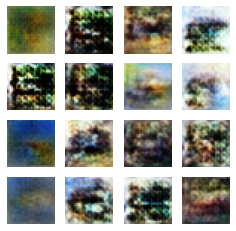

Time for training : 2229 sec


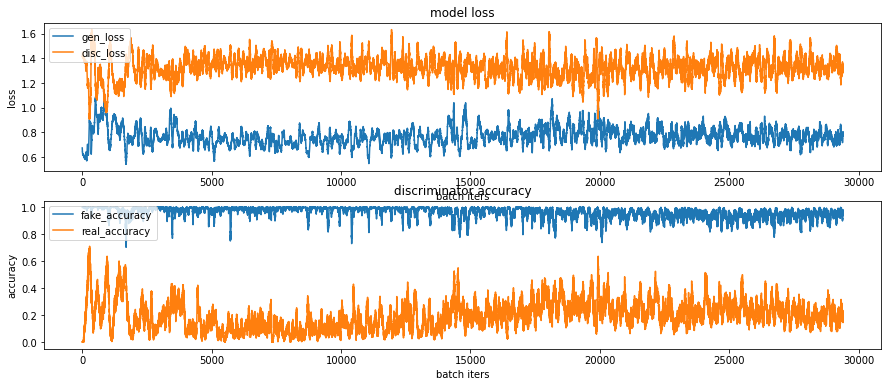

CPU times: user 38min 37s, sys: 3min 13s, total: 41min 50s
Wall time: 37min 11s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

## 학습과정 시각화하기

In [33]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1904088 Jan 23 15:28 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


## 회고
- 4번째 GAN 프로젝트를 끝마쳤다. 생성형 모델을 만드는 것을 해보면서 많이 어려웠던 부분들이 많았다. colab으로 작업하다가 gpu사용량을 넘어버려서 추가적으로 해보려고 했던 부분들을 작업을 하지 못하였다.
이 부분은 LMS 클라우드에서 다시 작업해보려고 한다. 많이 부족하지만.. 열심히 노력해야겠다는 생각 밖에 안들었다.